In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
import lightgbm as lgb
import catboost as ctb
from catboost import *
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, cross_val_score
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer

In [6]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [7]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [8]:
train_df = train.loc[:,"lat":"depth_original"]
test_df = test.loc[:,"lat":"depth_original"]
train_sea = train.loc[:,"cliff_length":"sst_diff"]
test_sea = test.loc[:,"cliff_length":"sst_diff"]
train_landsat = train.loc[:,"Blue":"Landsat_num"]
test_landsat = test.loc[:,"Blue":"Landsat_num"]
train_senti = train.loc[:,"MAX_AFRI1600":"MIN_WVP"]
test_senti = test.loc[:,"MAX_AFRI1600":"MIN_WVP"]
train_landsat_y = train.loc[:,"MAX_Blue_2000":]
test_landsat_y = test.loc[:,"MAX_Blue_2000":]

In [9]:
senti_ctg = train_senti.columns.to_list()
senti_max_ctg = [col for col in senti_ctg if "MAX" in col]
senti_feats = [col.split("_")[1] for col in senti_max_ctg]
senti_feats.append("MCARI_MTVI2")
senti_feats.append("MCARI_OSAVI")
senti_feats.append("Chlred_edge")
senti_feats.append("D678_500")
senti_feats.append("SR672_708")
senti_feats = set(senti_feats)
senti_feats.remove("MCARI")
senti_feats.remove("Chlred")
senti_feats.remove("D678")
senti_feats.remove("SR672")
senti_feats.remove("CI")
#senti_feats.remove("MAX")

landy_ctg = train_landsat_y.columns.to_list()
landy_ctg.remove("mesh20")
landy_feats = [col.split("_")[1] for col in landy_ctg]
landy_feats = set(landy_feats)

In [10]:
for col in senti_feats:
  train_senti[f"Diff_MAX_Min_{col}"] = train_senti[f"MAX_{col}"] - train_senti[f"MIN_{col}"]
  test_senti[f"Diff_MAX_Min_{col}"] = test_senti[f"MAX_{col}"] - test_senti[f"MIN_{col}"]

In [11]:
main_features = train_df.columns.to_list()
sea_features = train_sea.columns.to_list()
landsat_features = train_landsat.columns.to_list()
#senti_features = train_senti.columns.to_list()

In [12]:
landy_features = [f"lastyear_feature{col}" for col in range(150)]
landy_merge_feats = ["id"] + landy_features

In [13]:
print(sorted(train.year.unique().tolist()))
train.groupby("year")["id"].count()

[1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2006.0, 2009.0, 2010.0, 2011.0, 2012.0, 2019.0, 2020.0]


year
1999.0      87
2000.0      95
2001.0      16
2002.0      71
2003.0      54
2006.0       3
2009.0    3681
2010.0    2420
2011.0    3458
2012.0     101
2019.0    4113
2020.0      41
Name: id, dtype: int64

In [14]:
test.groupby("year")["id"].count()

year
2002.0     168
2004.0      41
2009.0     406
2010.0    1297
2011.0     298
2012.0      36
2013.0      19
2014.0     130
2019.0    1644
Name: id, dtype: int64

In [15]:
def landy_func(df):
  landy_df = pd.DataFrame()
  for y in sorted(df.year.unique().tolist()):
    y = int(y)
    _df = df.loc[df.year==y]
    if y==1999 or y==2000:
      continue
    tmp_feats = [col for col in landy_ctg if str(y-1) in col]
    for i, col in enumerate(tmp_feats):
      _df[f"lastyear_feature{i}"] = _df[col]
    #display(_df.head(3))
    landy_df = pd.concat([landy_df,_df])

  landy_df.sort_index(inplace=True)
  return landy_df
landy_train = landy_func(train)
landy_test = landy_func(test)

ストリーミング出力は最後の 5000 行に切り捨てられました。
<ipython-input-15-a7be4148b832>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[f"lastyear_feature{i}"] = _df[col]
<ipython-input-15-a7be4148b832>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[f"lastyear_feature{i}"] = _df[col]
<ipython-input-15-a7be4148b832>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [16]:
def sort_LandsatTime(df):
  df["Landsat_year"] = df["Date_Acquired"].astype("str").str[:4].apply(pd.Series)
  df["Landsat_month"] = df["Date_Acquired"].astype("str").str[4:6].apply(pd.Series)
  df["Landsat_day"] = df["Date_Acquired"].astype("str").str[6:8].apply(pd.Series)

  _df = df["Landsat_StartTime"].str.split(':').apply(pd.Series).astype(float)
  _df.columns = ["Landsat_second","Landsat_tmp"]
  df["Landsat_second"] = _df["Landsat_second"]
  _df2 = _df["Landsat_tmp"].astype(str).str.split('.').apply(pd.Series).astype(float)
  #_df2.colmns = ["Landsat_minute","Landsat_hour"]
  df["Landsat_minute"] = _df2[0]
  df["Landsat_hour"] = _df2[1]

  df.loc[df['Landsat_year'].str.startswith('n'), 'Landsat_year'] = np.nan
  df["Landsat_year"] = df["Landsat_year"].fillna(df["year"])
  df["Landsat_month"] = df["Landsat_month"].replace("",np.nan)
  df["Landsat_day"] = df["Landsat_month"].replace("",np.nan)
  df["Landsat_month"] = df["Landsat_month"].fillna(df["month"])
  df["Landsat_day"] = df["Landsat_day"].fillna(1)
  df["Landsat_hour"] = df["Landsat_hour"].fillna(0)
  df["Landsat_minute"] = df["Landsat_minute"].fillna(0)
  df["Landsat_second"] = df["Landsat_second"].fillna(0)

  for col in ["Landsat_year","Landsat_month","Landsat_day","Landsat_hour","Landsat_minute","Landsat_second"]:
    df[col] = df[col].astype(float)

  df["search_year"] = df["year"]
  df["search_month"] = df["month"]

  df["year"] = df["Landsat_year"]
  df["month"] = df["Landsat_month"]
  df["day"] = df["Landsat_day"]
  df["hour"] = df["Landsat_hour"]
  df["minute"] = df["Landsat_minute"]
  df["second"] = df["Landsat_second"]

  df["Landsat_time"] = pd.to_datetime(df[["year","month","day","hour","minute","second"]])
  df = df.sort_values("Landsat_time").reset_index(drop=True)
  return df

def sort_yearmonth(df):
  df['year-month'] = df.year.astype(int).astype(str) + '-' + df.month.astype(int).astype(str)
  df['year-month'] = pd.to_datetime(df['year-month'], format='%Y-%m')
  df = df.sort_values("year-month").reset_index(drop=True)
  return df

In [17]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  display(df_missing.head(3))
  return df_missing 

In [18]:
train_missing = missing_func(train)
test_missing = missing_func(test)

,total,percent
MAX_MCARI2_2011,10013,0.708133
MAX_SLAVI_2011,10013,0.708133
MED_SWIR1_2011,10013,0.708133


,total,percent
MED_Fe3_2011,2496,0.617975
MED_VARIgreen_2011,2496,0.617975
MIN_Green_2011,2496,0.617975


In [19]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = "cover"
print(target)

display(train[target].head(3))

cover


0    0.050
1    0.725
2    0.025
Name: cover, dtype: float64

In [20]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15) 
features.remove('id') 
features.remove("Date_Acquired")
#features.remove("Landsat_StartTime")
#features.remove("PRODUCT_ID")
#features.remove("Landsat_num")
#knn_features.remove('id')
knn_features.remove("Date_Acquired")
#knn_features.remove("Landsat_StartTime")
#knn_features.remove("PRODUCT_ID")
#knn_features.remove("Landsat_num")

In [21]:
len(features), len(knn_features)

(2257, 511)

In [22]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [23]:
len(features), len(knn_features)

(307, 61)

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    features.remove(mcol)

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

    features.append(mcol)

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-24-532bdd304887>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-24-532bdd304887>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/61 [00:01<01:27,  1.46s/it]<ipython-input-24-532bdd304887>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,NBR,CVI,CRI550,DSWI_5,AVI,GARI,VARIgreen,GVMI,PPR,Red,...,MCARI2,SLAVI,Chlred_edge,Green,Fe3,IR550,Cigreen,NLI,MSAVI,DVIMSS
0,0.945309,0.092327,-0.018408,-1.589210,-15.589754,-0.234759,-1.569704,0.938259,-0.290628,12.291277,...,1.024100,55.834898,2.733582,24.466267,0.502376,0.040873,-0.816220,0.243821,-1.371784,-1.499917
1,0.971470,0.675865,-0.000708,-0.043684,38.705406,-0.823061,0.464793,0.970958,-0.026466,50.989620,...,0.552047,3658.334622,0.724878,72.848259,0.699943,0.013727,-0.034399,0.979600,0.273709,117.831956
2,0.971226,0.120194,-0.009265,-1.404554,-21.318088,-0.096821,7.850269,0.966689,-0.191400,18.480610,...,0.782590,145.440316,2.362776,34.678707,0.532909,0.028836,-0.774456,0.535998,-1.195080,0.291149
3,0.953734,0.684340,-0.008770,-0.179699,6.558980,-0.071414,-2.024030,0.953268,-0.214287,14.259546,...,0.270452,1892.328698,0.958183,44.320086,0.491030,0.024398,-0.157885,0.973643,0.041603,104.321931
4,0.984011,0.048014,-0.015697,-2.558995,-10.890392,-0.300833,-1.148279,0.975787,-0.313422,9.919600,...,3.224675,44.545636,2.216966,30.404083,0.326259,0.032890,-0.852835,0.337366,-0.995109,0.818969
5,0.953734,0.684340,-0.008770,-0.179699,6.558980,-0.071414,-2.024030,0.953268,-0.214287,14.259546,...,0.270452,2450.831941,0.958183,44.320086,0.491030,0.024398,-0.157885,0.973643,0.041603,104.321931
6,0.973090,0.105371,-0.013132,-1.533611,-17.212898,-0.191909,-3.105288,0.967538,-0.247777,15.022129,...,1.082886,96.938546,2.341471,30.243046,0.496713,0.033065,-0.787863,0.465244,-1.149029,0.375503
7,0.944751,0.032844,-0.004799,-2.511033,-28.176980,-0.055762,-50.824985,0.938661,-0.153107,19.299984,...,4.088720,101.353342,3.703350,55.338951,0.348759,0.018070,-0.905826,0.169172,-2.085822,-6.792398
8,0.951746,0.095480,-0.010057,-1.647455,-19.278593,-0.193910,-3.133206,0.947639,-0.239956,17.650833,...,1.437299,142.997158,2.203177,38.484325,0.458650,0.025985,-0.791823,0.568627,-1.065772,1.576855
9,0.965199,0.082666,-0.016590,-1.765473,-13.479237,-0.240419,-1.695201,0.958180,-0.278412,11.636496,...,1.608101,57.407128,2.376309,26.254721,0.443215,0.038088,-0.813486,0.346556,-1.130413,0.116010


,NBR,CVI,CRI550,DSWI_5,AVI,GARI,VARIgreen,GVMI,PPR,Red,...,MCARI2,SLAVI,Chlred_edge,Green,Fe3,IR550,Cigreen,NLI,MSAVI,DVIMSS
0,0.953734,0.684340,-0.009824,-0.179699,6.558980,-0.071414,-0.463801,0.953268,-0.218289,15.224933,...,0.270452,2929.223006,0.958183,39.832272,0.524295,0.026776,-0.157885,0.973643,0.041603,104.321931
1,0.947572,0.226427,-0.014651,-1.062207,-13.808917,-0.265296,-0.764773,0.943496,-0.258153,19.557796,...,0.570256,332.337665,1.844508,31.486661,0.598426,0.034294,-0.641057,0.629474,-0.735316,10.810214
2,0.934909,0.357271,-0.013097,-0.634740,-19.166557,-0.097316,-1.399575,0.933827,-0.266970,13.552936,...,0.301703,109.342950,1.349551,35.395773,0.481037,0.030635,-0.480357,0.908728,-0.340387,30.533786
3,0.983847,0.057112,-0.016728,-2.118620,-14.263588,-0.283029,-1.144489,0.975033,-0.315875,11.296329,...,2.383858,47.185164,2.712507,28.700424,0.393594,0.034843,-0.854896,0.211141,-1.337254,-1.301446
4,0.966725,0.077599,-0.006159,-1.478979,-36.870170,0.053439,1.912993,0.960639,-0.148981,24.134905,...,0.154940,138.114280,4.234328,42.104111,0.573220,0.023751,-0.864626,0.147521,-2.478195,-10.455337
5,0.958511,0.689209,-0.000449,-0.126377,15.586884,-0.969892,0.294335,0.958125,-0.023003,82.391744,...,0.290122,3194.123169,0.944274,104.354541,0.785732,0.009705,-0.113644,0.978339,0.055931,134.052702
6,0.970220,0.082369,-0.015169,-1.845007,-13.700280,-0.258502,-1.548610,0.963987,-0.284961,12.489099,...,1.756099,70.906138,2.214788,29.240328,0.427119,0.034199,-0.807151,0.435992,-1.029521,1.044402
7,0.941589,0.052659,-0.010128,-2.113518,-19.287441,-0.167193,-2.842335,0.935326,-0.232666,14.640511,...,2.558447,73.906687,2.929983,37.272316,0.392799,0.026830,-0.865938,0.260737,-1.538986,-2.648215
8,0.982552,0.091107,-0.014280,-1.722533,-13.437099,-0.214173,-2.438843,0.976178,-0.251481,12.494470,...,1.556755,72.460664,2.163200,28.144505,0.443940,0.035531,-0.794776,0.455053,-0.992111,1.367738
9,0.948881,0.742347,-0.008693,-0.169558,-4.503057,0.252221,-2.024030,0.948410,-0.201572,14.259546,...,0.131115,1892.328698,1.031964,41.324984,0.491030,0.025655,-0.157355,0.970928,-0.031718,95.675323


In [25]:
main_features = [col for col in features if col in main_features]
sea_features = [col for col in features if col in sea_features]
lansat_features = [col for col in features if col in landsat_features]

In [26]:
train = train.merge(landy_train[landy_merge_feats], how="left", on="id")
test = test.merge(landy_test[landy_merge_feats], how="left", on="id")

In [27]:
train.lastyear_feature140.isnull().sum() / len(train)

0.2987977369165488

In [28]:
train

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,lastyear_feature140,lastyear_feature141,lastyear_feature142,lastyear_feature143,lastyear_feature144,lastyear_feature145,lastyear_feature146,lastyear_feature147,lastyear_feature148,lastyear_feature149
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.000000,...,0.292885,0.604033,0.283713,-0.293073,-0.815541,-1.748243,2.279157,54.299478,5.789215,-1.475328
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.000000,...,0.970890,0.365951,0.242038,-0.112101,-0.078021,1.944935,3.681952,1093.154059,-0.442386,0.828126
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.000000,...,0.239561,0.577119,0.296503,-0.197949,-0.800520,-2.414575,3.046994,71.423986,3.635673,2.616766
3,3,26.991255,127.912302,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.575,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,26.988254,127.917254,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.225,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,14135,24.728611,125.403889,20.0,20110925,2011.0,9.0,0.050,NaN,1294.458862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14136,14136,27.002425,127.927444,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.300,NaN,0.000000,...,-0.102032,0.694074,0.250117,-0.145779,-0.886885,-2.841663,4.748102,59.947341,4.504016,33.582980
14137,14137,24.797444,125.162417,20.0,20120204.0,2012.0,2.0,0.050,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14138,14138,26.999893,127.922014,40.0,2009.4.3-2009.5.15,2009.0,4.0,0.425,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(set(landy_features)):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    landy_features.remove(mcol)

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[landy_features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[landy_features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[landy_features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

    landy_features.append(mcol)

display(train[landy_features].head(10))
display(test[landy_features].head(10))

  0%|          | 0/150 [00:00<?, ?it/s]<ipython-input-29-0c6dd4642a50>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[landy_features])
<ipython-input-29-0c6dd4642a50>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[landy_features])
  1%|          | 1/150 [00:00<02:24,  1.03it/s]<ipython-input-29-0c6dd4642a50>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,lastyear_feature121,lastyear_feature102,lastyear_feature122,lastyear_feature6,lastyear_feature26,lastyear_feature72,lastyear_feature119,lastyear_feature133,lastyear_feature101,lastyear_feature35,...,lastyear_feature55,lastyear_feature4,lastyear_feature139,lastyear_feature80,lastyear_feature76,lastyear_feature66,lastyear_feature86,lastyear_feature56,lastyear_feature108,lastyear_feature74
0,-0.588795,11.679468,2.449589,8.385872,0.077491,2.449589,-0.018230,1.539325,24.865967,-0.084241,...,0.070833,0.358096,1.343425,0.030660,0.077491,0.087289,-0.294061,8.385872,-0.674071,0.066481
1,74.516054,25.809914,2.881928,8.438723,0.053488,2.881928,-0.005166,1.485689,39.023602,-0.215958,...,0.340542,2.235927,0.655223,0.086631,0.053488,0.708490,-0.764377,8.438723,0.163008,-0.236691
2,-2.876180,14.573886,2.250039,8.726562,0.080411,2.304842,-0.011220,1.523477,29.454432,-0.046694,...,0.121159,0.700271,0.878748,0.021970,0.065692,0.089916,-0.229109,8.558640,-0.763055,0.114472
3,106.744913,74.866726,1.997231,8.897596,0.105833,2.036253,0.001448,-0.408568,88.757451,0.134038,...,1.345420,8.456374,0.183189,0.102544,0.100817,0.697331,-0.060301,8.882938,-0.121121,0.386985
4,106.744913,74.866726,1.997231,8.897596,0.105833,2.036253,0.001448,-0.408568,88.757451,0.134038,...,1.345420,8.456374,0.183189,0.102544,0.100817,0.697331,-0.060301,8.882938,-0.121121,0.386985
5,-9.481022,18.589273,2.702364,8.370502,0.069089,2.702364,-0.004990,1.541448,47.148434,-0.018938,...,0.071676,0.262200,3.422985,0.014105,0.069089,0.031736,-0.142601,8.370502,-0.986873,0.106872
6,106.744913,74.866726,1.997231,8.897596,0.105833,2.036253,0.001448,-0.408568,88.757451,0.134038,...,1.345420,8.456374,0.183189,0.102544,0.100817,0.697331,-0.060301,8.882938,-0.121121,0.386985
7,-8.702355,16.832077,2.746463,9.228143,0.168127,2.879400,-0.007677,1.552478,43.656136,-0.020063,...,0.112522,1.406822,2.533701,0.031154,0.107231,0.043189,-0.216052,8.766761,-0.972534,0.076544
8,-0.503141,9.701298,2.544860,8.922568,0.086609,2.910955,-0.016428,1.534269,24.986958,-0.058470,...,0.088022,0.555657,1.432577,0.021833,0.051711,0.064574,-0.322610,8.577352,-0.671461,0.056455
9,0.213968,15.515742,2.559431,8.788394,0.116999,2.559431,-0.012861,1.555325,35.120041,-0.084292,...,0.132785,0.766818,1.652052,0.049422,0.116999,0.082446,-0.320086,8.788394,-0.639275,0.059000


,lastyear_feature121,lastyear_feature102,lastyear_feature122,lastyear_feature6,lastyear_feature26,lastyear_feature72,lastyear_feature119,lastyear_feature133,lastyear_feature101,lastyear_feature35,...,lastyear_feature55,lastyear_feature4,lastyear_feature139,lastyear_feature80,lastyear_feature76,lastyear_feature66,lastyear_feature86,lastyear_feature56,lastyear_feature108,lastyear_feature74
0,-14.007048,30.392052,2.095754,9.190916,0.099747,2.133843,-0.001844,1.478887,60.133713,-0.009712,...,0.130811,0.748182,0.786925,0.022222,0.091862,0.064181,-0.128763,8.989655,-0.929172,0.194207
1,-0.489473,11.807753,2.496634,8.520046,0.133874,2.624863,-0.014267,1.541358,28.513741,-0.067284,...,0.258829,1.901043,1.271236,0.047859,0.094736,0.094701,-0.333360,8.452959,-0.669037,0.066814
2,2.712553,12.962998,2.512445,8.900705,0.085533,2.997464,-0.010763,1.549916,36.441475,-0.070017,...,0.127799,0.724468,1.288566,0.031741,0.063846,0.081732,-0.380701,8.744974,-0.550904,0.050860
3,-1.846723,9.362045,2.051087,8.251698,0.129235,2.226415,-0.033550,1.541995,19.809486,-0.105057,...,0.074004,1.744220,0.401266,0.030028,0.089776,0.099302,-0.300564,8.212267,-0.760654,0.044580
4,-30.158755,41.707432,1.585784,8.913291,0.141794,1.607305,-0.002457,1.520636,62.655739,-0.012668,...,0.135948,2.792405,-2.183686,0.014995,0.085865,0.077380,-0.076281,8.866989,-1.148262,0.312544
5,134.373564,66.516792,2.051831,9.607972,0.168125,2.051831,-0.000845,1.432965,81.651833,-0.070755,...,2.786510,14.072751,0.361913,0.211567,0.168125,0.835117,-0.304012,9.607972,0.018241,-0.246969
6,106.744913,74.866726,1.997231,8.897596,0.105833,2.036253,0.001448,-0.408568,88.757451,0.134038,...,1.345420,8.456374,0.183189,0.102544,0.100817,0.697331,-0.060301,8.882938,-0.121121,0.386985
7,-1.297108,19.924486,2.077543,9.264612,0.311594,2.234781,-0.009105,1.531830,37.286346,-0.060160,...,0.414386,3.629423,0.774547,0.063444,0.145534,0.119933,-0.301284,8.770490,-0.675297,0.087667
8,-2.042119,9.731532,1.864560,8.788394,0.192708,2.290092,-0.036507,-1.495315,19.170443,0.017997,...,0.177765,26.646191,0.212541,0.042811,0.094883,0.121203,-0.322084,8.251698,-0.768847,0.070214
9,0.424410,12.168788,2.587656,8.452959,0.066945,2.587656,-0.015480,1.539596,27.150440,-0.081226,...,0.067869,0.351273,1.545212,0.028867,0.066945,0.086620,-0.319162,8.452959,-0.627086,0.063619


In [30]:
train_ls = sort_LandsatTime(train)
train_df = sort_yearmonth(train)

## Model

In [31]:
class CFG:
  ver=72
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  boosting_type="dart"

In [32]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [33]:
#features = list(features)
#features.remove('area')
#main_features.remove("year")
#features.remove("month")
#features.append("mesh20")

In [34]:
params = [{
        'objective': ['regression'],
        'metric': ['rmse'],
        'learning_rate': [0.1, 0.05],
        'boosting': ["gbdt"],
        'seed': [CFG.seed],
        "reg_alpha": [0.5],
        "reg_lambda": [0.5],
        "n_estimators": [3000],
        'min_child_weight': [1, 5],
        "max_depth": [3, 5, 7],
        "colsample_bytree": [0.4, 0.7, 1.0],
    }]

In [35]:
def get_pred(df, test, candidate_params, feats, model, pred_name="", isLandsat=False):
  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), CFG.n_folds))

  X = df[feats].values
  y = df[target].values

  inner_cv = TimeSeriesSplit(n_splits=3)
  outer_cv = TimeSeriesSplit(n_splits=8)

  clf = model
  for fold, (tr_index, va_index) in enumerate(outer_cv.split(df)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    outer_train = train.iloc[tr_index]
    outer_valid = train.iloc[va_index]
    
    outer_train = outer_train.sort_values("year-month").reset_index(drop=True)

    print(f"train period : {str(outer_train.iloc[0].year)}年{str(outer_train.iloc[0].month)}月 ～ {str(outer_train.iloc[-1].year)}年{str(outer_train.iloc[-1].month)}月")
    print(f"valid period : {str(outer_valid.iloc[0].year)}年{str(outer_valid.iloc[0].month)}月 ～ {str(outer_valid.iloc[-1].year)}年{str(outer_valid.iloc[-1].month)}月")

    if isLandsat:
      outer_train = outer_train.sort_values("Landsat_time").reset_index(drop=True)
    else:
      outer_train = outer_train.sort_values("year-month").reset_index(drop=True)

    outer_tr_X = outer_train[feats].values
    outer_va_X = outer_valid[feats].values
    test_X = test[feats].values
    outer_tr_y = outer_train[target].values
    outer_va_y = outer_valid[target].values

    gs = GridSearchCV(estimator=clf,
                      param_grid=candidate_params,
                      cv=inner_cv,
                      scoring=make_scorer(mean_squared_error,greater_is_better=False),
                      return_train_score=True,
                      n_jobs=-1)
    gs.fit(outer_tr_X, outer_tr_y,
           eval_set=[(outer_va_X, outer_va_y)],
           early_stopping_rounds=50,
           verbose = 200)
    print('The best parameter = ', gs.best_params_)
      
    outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)
    oof_df = pd.concat([oof_df, outer_valid])

    print('RMSE = ',mean_squared_error(outer_va_y, outer_valid[f"{pred_name}_pred"], squared=False))

    test_preds[:, fold] = gs.best_estimator_.predict(test_X)

  return oof_df, test_preds

In [36]:
model = lgb.LGBMRegressor()

oof_main, test_main = get_pred(train_df, test, params, main_features, model, "main")
oof_sea, test_sea = get_pred(train_df, test, params, sea_features, model, "sea")
oof_landsat, test_landsat = get_pred(train_ls, test, params, lansat_features, model, "landsat", isLandsat=True)
oof_landsat_ly, test_landsat_ly = get_pred(train_df, test, params, landy_features, model, "last_year_landsat")

===============  OUTER CV FOLD 0  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2010.0年11.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.186915
[400]	valid_0's rmse: 0.18405
[600]	valid_0's rmse: 0.182488
[800]	valid_0's rmse: 0.181442
[1000]	valid_0's rmse: 0.180664
[1200]	valid_0's rmse: 0.180241
[1400]	valid_0's rmse: 0.179819
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.1797492749722127
===============  OUTER CV FOLD 1  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.176738
[400]	valid_0's rmse: 0.172478
[600]	valid_0's rmse: 0.170382
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.169972062573112
===============  OUTER CV FOLD 2  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年6.0月 ～ 2012.0年1.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.186997
[400]	valid_0's rmse: 0.180979
[600]	valid_0's rmse: 0.17845
[800]	valid_0's rmse: 0.176259
[1000]	valid_0's rmse: 0.174981
[1200]	valid_0's rmse: 0.174168
[1400]	valid_0's rmse: 0.173505
[1600]	valid_0's rmse: 0.173158
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.17297006347163374
===============  OUTER CV FOLD 3  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.156142
[400]	valid_0's rmse: 0.150368
[600]	valid_0's rmse: 0.147959
[800]	valid_0's rmse: 0.146529
[1000]	valid_0's rmse: 0.145282
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.14521086303705844
===============  OUTER CV FOLD 4  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年4.0月 ～ 2009.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.1606
[400]	valid_0's rmse: 0.15451
[600]	valid_0's rmse: 0.150682
[800]	valid_0's rmse: 0.148558
[1000]	valid_0's rmse: 0.14725
[1200]	valid_0's rmse: 0.146067
[1400]	valid_0's rmse: 0.145462
[1600]	valid_0's rmse: 0.14483
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.14471006137599454


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 5  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2009.0年7.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.155832
[400]	valid_0's rmse: 0.150921
[600]	valid_0's rmse: 0.148112
[800]	valid_0's rmse: 0.146772
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.1467263414744546
===============  OUTER CV FOLD 6  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2003.0年3.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.164187
[400]	valid_0's rmse: 0.156895
[600]	valid_0's rmse: 0.153174
[800]	valid_0's rmse: 0.150669
[1000]	valid_0's rmse: 0.14907
[1200]	valid_0's rmse: 0.148171
[1400]	valid_0's rmse: 0.147303
[1600]	valid_0's rmse: 0.146198
[1800]	valid_0's rmse: 0.145669
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.14522891833525703
===============  OUTER CV FOLD 7  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2010.0年9.0月 ～ 2009.0年11.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.152292
[400]	valid_0's rmse: 0.144494
[600]	valid_0's rmse: 0.141037
[800]	valid_0's rmse: 0.138226
[1000]	valid_0's rmse: 0.1366
[1200]	valid_0's rmse: 0.135286
[1400]	valid_0's rmse: 0.134223
[1600]	valid_0's rmse: 0.133525
[1800]	valid_0's rmse: 0.13287
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.13256900481878028
===============  OUTER CV FOLD 0  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2010.0年11.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.173013
[400]	valid_0's rmse: 0.166943
[600]	valid_0's rmse: 0.164494
[800]	valid_0's rmse: 0.163187
[1000]	valid_0's rmse: 0.162314
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.16198416190256704


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 1  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.15718
[400]	valid_0's rmse: 0.15093
[600]	valid_0's rmse: 0.147361
[800]	valid_0's rmse: 0.146162
[1000]	valid_0's rmse: 0.145834
[1200]	valid_0's rmse: 0.144961
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE = 

<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


 0.14481384972031355
===============  OUTER CV FOLD 2  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年6.0月 ～ 2012.0年1.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.14523
[400]	valid_0's rmse: 0.140299
[600]	valid_0's rmse: 0.137863
[800]	valid_0's rmse: 0.136442
[1000]	valid_0's rmse: 0.135836
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.1358365505602132


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 3  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.140168
[400]	valid_0's rmse: 0.134174
[600]	valid_0's rmse: 0.132456
[800]	valid_0's rmse: 0.131448
[1000]	valid_0's rmse: 0.130886
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.130850687357782
===============  OUTER CV FOLD 4  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年4.0月 ～ 2009.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.138
[400]	valid_0's rmse: 0.129968
[600]	valid_0's rmse: 0.126435
[800]	valid_0's rmse: 0.124881
[1000]	valid_0's rmse: 0.12362
[1200]	valid_0's rmse: 0.122983
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.12295453383464333
===============  OUTER CV FOLD 5  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2009.0年7.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.139136
[400]	valid_0's rmse: 0.131945
[600]	valid_0's rmse: 0.128308
[800]	valid_0's rmse: 0.126235
[1000]	valid_0's rmse: 0.124784
[1200]	valid_0's rmse: 0.124106
[1400]	valid_0's rmse: 0.123653
[1600]	valid_0's rmse: 0.123382
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.12328512566045859
===============  OUTER CV FOLD 6  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2003.0年3.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.164182
[400]	valid_0's rmse: 0.153192
[600]	valid_0's rmse: 0.146877
[800]	valid_0's rmse: 0.142716
[1000]	valid_0's rmse: 0.140088
[1200]	valid_0's rmse: 0.137846
[1400]	valid_0's rmse: 0.135987
[1600]	valid_0's rmse: 0.134595
[1800]	valid_0's rmse: 0.133384
[2000]	valid_0's rmse: 0.132361
[2200]	valid_0's rmse: 0.131457
[2400]	valid_0's rmse: 0.130732
[2600]	valid_0's rmse: 0.130245
[2800]	valid_0's rmse: 0.129707
[3000]	valid_0's rmse: 0.129384
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.1293656991400481
===============  OUTER CV FOLD 7  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2010.0年9.0月 ～ 2009.0年11.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.144559
[400]	valid_0's rmse: 0.133337
[600]	valid_0's rmse: 0.127072
[800]	valid_0's rmse: 0.123435
[1000]	valid_0's rmse: 0.121041
[1200]	valid_0's rmse: 0.11922
[1400]	valid_0's rmse: 0.1177
[1600]	valid_0's rmse: 0.116622
[1800]	valid_0's rmse: 0.115756
[2000]	valid_0's rmse: 0.115095
[2200]	valid_0's rmse: 0.114516
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.1142963901511275
===============  OUTER CV FOLD 0  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2010.0年11.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.194982
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.19466855039370975
===============  OUTER CV FOLD 1  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.170875
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.1705759175433121
===============  OUTER CV FOLD 2  ===============


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年6.0月 ～ 2012.0年1.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.18112
[400]	valid_0's rmse: 0.176097
[600]	valid_0's rmse: 0.174051
[800]	valid_0's rmse: 0.173113
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.17257910150365385
===============  OUTER CV FOLD 3  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.165171
[400]	valid_0's rmse: 0.162595
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.16202561088631093


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 4  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年4.0月 ～ 2009.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.158529
[400]	valid_0's rmse: 0.157018
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.15693651672777903


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 5  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2009.0年7.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.157523
[400]	valid_0's rmse: 0.152306
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.15200111542076428


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 6  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2003.0年3.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.158191
[400]	valid_0's rmse: 0.156012
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.1559778930757947
===============  OUTER CV FOLD 7  ===============


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2010.0年9.0月 ～ 2009.0年11.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.153314
[400]	valid_0's rmse: 0.148831
[600]	valid_0's rmse: 0.147881
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.14776726304207213
===============  OUTER CV FOLD 0  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2010.0年11.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.197466
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.19732717561544744
===============  OUTER CV FOLD 1  ===============
train period : 1999.0年11.0月 ～ 2019.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.192963
[400]	valid_0's rmse: 0.191384
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.19111798285850348
===============  OUTER CV FOLD 2  ===============


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年6.0月 ～ 2012.0年1.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.176572
[400]	valid_0's rmse: 0.175625
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.17559452728267208
===============  OUTER CV FOLD 3  ===============


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.176726
[400]	valid_0's rmse: 0.175213
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.17505013223132046


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 4  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2011.0年4.0月 ～ 2009.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.183048
[400]	valid_0's rmse: 0.180555
[600]	valid_0's rmse: 0.180015
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.17998807174976014
===============  OUTER CV FOLD 5  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2009.0年7.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.174944
[400]	valid_0's rmse: 0.172298
[600]	valid_0's rmse: 0.171538
[800]	valid_0's rmse: 0.171312
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.17131151833159686
===============  OUTER CV FOLD 6  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2003.0年3.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.173562
[400]	valid_0's rmse: 0.171415
[600]	valid_0's rmse: 0.170872
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.17075508880709442


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 7  ===============
train period : 1999.0年8.0月 ～ 2019.0年12.0月
valid period : 2010.0年9.0月 ～ 2009.0年11.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[200]	valid_0's rmse: 0.182642
[400]	valid_0's rmse: 0.179321
[600]	valid_0's rmse: 0.178207
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 3000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.1780308776232788


<ipython-input-35-274fe4b674c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid[f"{pred_name}_pred"] = gs.best_estimator_.predict(outer_va_X)


In [37]:
lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': 42,
        "reg_alpha":0.1,
        #'reg_lambda': 0.5,
        "n_estimators":4000,
        'min_child_weight': 1,
        'colsample_bytree': 0.4
    }

def get_oof_LGBM_pred(df, test, oof_features):
  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), 15))
  lgbm_params["n_estimators"] = 5000

  cv = TimeSeriesSplit(n_splits=15)

  for fold, (tr_index, va_index) in enumerate(cv.split(df)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    train_folds = train.iloc[tr_index]
    valid_folds = train.iloc[va_index]


    print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
    print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


    train_X = train_folds[oof_features].values
    valid_X = valid_folds[oof_features].values
    test_X = test[oof_features].values
    train_labels = train_folds[target].values
    valid_labels = valid_folds[target].values

    lgbm_params["n_estimators"] += 250
    clf = lgb.LGBMRegressor(**lgbm_params)
    clf.fit(train_X, train_labels,
            eval_set=[(valid_X, valid_labels)],
            verbose = 1000,
            early_stopping_rounds=50)
      
    valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
    test_preds[:, fold] = clf.predict(test_X)
    oof_df = pd.concat([oof_df, valid_folds])


    get_score(valid_labels, valid_folds["lgbm_pred"])

  get_score(oof_df[target], oof_df[f"lgbm_pred"])
  return oof_df,  test_preds


cat_params = {
        "loss_function":"RMSE",
        "n_estimators":6000,
        "random_seed":2022,
        "learning_rate":0.05
  }

def get_oof_Cat_pred(df, test, oof_features):
  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), 15))

  cv = TimeSeriesSplit(n_splits=15)

  for fold, (tr_index, va_index) in enumerate(cv.split(df)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    train_folds = train.iloc[tr_index]
    valid_folds = train.iloc[va_index]


    print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
    print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


    train_X = train_folds[oof_features].values
    valid_X = valid_folds[oof_features].values
    test_X = test[oof_features].values
    train_labels = train_folds[target].values
    valid_labels = valid_folds[target].values

    #clf = model
    clf = ctb.CatBoostRegressor(**cat_params,
                                    #task_type='GPU'
                                    )
    clf.fit(train_X, train_labels,
              eval_set=[(train_X,train_labels),(valid_X, valid_labels)],
              verbose = 200,
              early_stopping_rounds = 50,
              #cat_features=categorical_features,
              use_best_model=True
          )
      
    valid_folds[f"cat_pred"] = clf.predict(valid_X)
    test_preds[:, fold] = clf.predict(test_X)
    oof_df = pd.concat([oof_df, valid_folds])


    get_score(valid_labels, valid_folds["cat_pred"])

  get_score(oof_df[target], oof_df[f"cat_pred"])
  return oof_df,  test_preds

In [38]:
train = train.merge(oof_main[["id","main_pred"]], how="left", on="id").merge(oof_sea[["id","sea_pred"]], how="left", on="id").merge(oof_landsat[["id","landsat_pred"]], how="left", on="id").merge(oof_landsat_ly[["id","last_year_landsat_pred"]], how="left", on="id")
oof_train = sort_yearmonth(train)
oof_features = ["main_pred","sea_pred","landsat_pred","last_year_landsat_pred"]

oof_train = oof_train.dropna(subset=["main_pred","sea_pred","landsat_pred","last_year_landsat_pred"]).reset_index(drop=True)

get_score(oof_train["cover"], oof_train["main_pred"])
get_score(oof_train["cover"], oof_train["sea_pred"])
get_score(oof_train["cover"], oof_train["landsat_pred"])
get_score(oof_train["cover"], oof_train["last_year_landsat_pred"])

pred_df = test.copy()
pred_df["main_pred"] = np.mean(test_main, axis=1)
pred_df["sea_pred"] = np.mean(test_sea, axis=1)
pred_df["landsat_pred"] = np.mean(test_landsat, axis=1)
pred_df["last_year_landsat_pred"] = np.mean(test_landsat_ly, axis=1)

oof_lgbm, preds_lgbm = get_oof_LGBM_pred(oof_train, pred_df, oof_features)
oof_cat, preds_cat = get_oof_Cat_pred(oof_train, pred_df, oof_features)

RMSE 0.15545929628649396
RMSE 0.1336504672379495
RMSE 0.1646684204485395
RMSE 0.1801165318759664
===============  OUTER CV FOLD 0  ===============
train period : 2012.0年1.0月 ～ 2010.0年11.0月
valid period : 2009.0年12.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[1000]	valid_0's rmse: 0.320386


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2000]	valid_0's rmse: 0.320386
[3000]	valid_0's rmse: 0.320386
[4000]	valid_0's rmse: 0.320386
[5000]	valid_0's rmse: 0.320386
RMSE 0.2764099550621009
===============  OUTER CV FOLD 1  ===============
train period : 2012.0年1.0月 ～ 2009.0年10.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[1000]	valid_0's rmse: 0.329638
[2000]	valid_0's rmse: 0.329638
[3000]	valid_0's rmse: 0.329638
[4000]	valid_0's rmse: 0.329638


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

[5000]	valid_0's rmse: 0.329638
RMSE 0.25879941646246185
===============  OUTER CV FOLD 2  ===============
train period : 2012.0年1.0月 ～ 2009.0年12.0月
valid period : 2019.0年11.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

[1000]	valid_0's rmse: 0.17196
[2000]	valid_0's rmse: 0.176117
[3000]	valid_0's rmse: 0.178526
[4000]	valid_0's rmse: 0.180238
[5000]	valid_0's rmse: 0.18152


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.18189143664330462
===============  OUTER CV FOLD 3  ===============
train period : 2012.0年1.0月 ～ 2010.0年12.0月
valid period : 2010.0年10.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.158778
[2000]	valid_0's rmse: 0.161436
[3000]	valid_0's rmse: 0.163821
[4000]	valid_0's rmse: 0.166871
[5000]	valid_0's rmse: 0.169239
[6000]	valid_0's rmse: 0.170896


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.1708955392945053
===============  OUTER CV FOLD 4  ===============
train period : 2012.0年1.0月 ～ 2011.0年7.0月
valid period : 2009.0年8.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.141978
[2000]	valid_0's rmse: 0.145758
[3000]	valid_0's rmse: 0.148625
[4000]	valid_0's rmse: 0.151155
[5000]	valid_0's rmse: 0.153156
[6000]	valid_0's rmse: 0.15433


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.15443645590230082
===============  OUTER CV FOLD 5  ===============
train period : 2012.0年1.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.140586
[2000]	valid_0's rmse: 0.146797
[3000]	valid_0's rmse: 0.15048
[4000]	valid_0's rmse: 0.153305
[5000]	valid_0's rmse: 0.155724
[6000]	valid_0's rmse: 0.156642


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.1569465875316593
===============  OUTER CV FOLD 6  ===============
train period : 2012.0年1.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.137515
[2000]	valid_0's rmse: 0.141433
[3000]	valid_0's rmse: 0.14312
[4000]	valid_0's rmse: 0.145938
[5000]	valid_0's rmse: 0.147046
[6000]	valid_0's rmse: 0.147918


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.14928564478540865
===============  OUTER CV FOLD 7  ===============
train period : 2012.0年1.0月 ～ 2011.0年7.0月
valid period : 2009.0年1.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.125257
[2000]	valid_0's rmse: 0.128552
[3000]	valid_0's rmse: 0.132529
[4000]	valid_0's rmse: 0.13477
[5000]	valid_0's rmse: 0.1366
[6000]	valid_0's rmse: 0.138316
[7000]	valid_0's rmse: 0.139794


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.13979376408917193
===============  OUTER CV FOLD 8  ===============
train period : 2012.0年1.0月 ～ 2009.0年12.0月
valid period : 2019.0年9.0月 ～ 2009.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.14214
[2000]	valid_0's rmse: 0.146819
[3000]	valid_0's rmse: 0.150227
[4000]	valid_0's rmse: 0.152696
[5000]	valid_0's rmse: 0.155358
[6000]	valid_0's rmse: 0.157171
[7000]	valid_0's rmse: 0.158838


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.1592394119110524
===============  OUTER CV FOLD 9  ===============
train period : 2012.0年1.0月 ～ 2009.0年8.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.125365
[2000]	valid_0's rmse: 0.128227
[3000]	valid_0's rmse: 0.130775
[4000]	valid_0's rmse: 0.132463
[5000]	valid_0's rmse: 0.134501
[6000]	valid_0's rmse: 0.135936
[7000]	valid_0's rmse: 0.137367


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.13826377464987027
===============  OUTER CV FOLD 10  ===============
train period : 2012.0年1.0月 ～ 2019.0年10.0月
valid period : 2011.0年7.0月 ～ 2009.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.130228
[2000]	valid_0's rmse: 0.133255
[3000]	valid_0's rmse: 0.135597
[4000]	valid_0's rmse: 0.137669
[5000]	valid_0's rmse: 0.13918
[6000]	valid_0's rmse: 0.140173
[7000]	valid_0's rmse: 0.141766


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.1428886064152953
===============  OUTER CV FOLD 11  ===============
train period : 2012.0年1.0月 ～ 2009.0年7.0月
valid period : 2019.0年10.0月 ～ 2009.0年11.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.121406
[2000]	valid_0's rmse: 0.125178
[3000]	valid_0's rmse: 0.127418
[4000]	valid_0's rmse: 0.129232
[5000]	valid_0's rmse: 0.131077
[6000]	valid_0's rmse: 0.132216
[7000]	valid_0's rmse: 0.13371
[8000]	valid_0's rmse: 0.134947


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.13494701259586836
===============  OUTER CV FOLD 12  ===============
train period : 2012.0年1.0月 ～ 2009.0年11.0月
valid period : 2012.0年1.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.116278
[2000]	valid_0's rmse: 0.120167
[3000]	valid_0's rmse: 0.12324
[4000]	valid_0's rmse: 0.124838
[5000]	valid_0's rmse: 0.126273
[6000]	valid_0's rmse: 0.127947
[7000]	valid_0's rmse: 0.129083
[8000]	valid_0's rmse: 0.130359


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.13033560279040984
===============  OUTER CV FOLD 13  ===============
train period : 2012.0年1.0月 ～ 2010.0年8.0月
valid period : 2003.0年3.0月 ～ 2019.0年11.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.126558
[2000]	valid_0's rmse: 0.13081
[3000]	valid_0's rmse: 0.133345
[4000]	valid_0's rmse: 0.135935
[5000]	valid_0's rmse: 0.138332
[6000]	valid_0's rmse: 0.139215
[7000]	valid_0's rmse: 0.14128
[8000]	valid_0's rmse: 0.142854


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.14335043095588637
===============  OUTER CV FOLD 14  ===============
train period : 2012.0年1.0月 ～ 2019.0年11.0月
valid period : 2009.0年12.0月 ～ 2009.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.127048
[2000]	valid_0's rmse: 0.130047
[3000]	valid_0's rmse: 0.130842
[4000]	valid_0's rmse: 0.131214
[5000]	valid_0's rmse: 0.132368
[6000]	valid_0's rmse: 0.13402
[7000]	valid_0's rmse: 0.135469
[8000]	valid_0's rmse: 0.13644


<ipython-input-37-fa5c100734d8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.13699047700661626
RMSE 0.17036935360150499
===============  OUTER CV FOLD 0  ===============
train period : 2012.0年1.0月 ～ 2010.0年11.0月
valid period : 2009.0年12.0月 ～ 2009.0年10.0月
0:	learn: 0.2634216	test: 0.2634216	test1: 0.2764100	best: 0.2764100 (0)	total: 69.1ms	remaining: 6m 54s
200:	learn: 0.2634216	test: 0.2634216	test1: 0.2764100	best: 0.2764100 (200)	total: 85.4ms	remaining: 2.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2764099545
bestIteration = 315

Shrink model to first 316 iterations.
RMSE 0.2764099550621009
===============  OUTER CV FOLD 1  ===============
train period : 2012.0年1.0月 ～ 2009.0年10.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
0:	learn: 0.2697880	test: 0.2697880	test1: 0.2556536	best: 0.2556536 (0)	total: 373us	remaining: 2.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2125892579
bestIteration = 50

Shrink model to first 51 iterations.


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)
<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


RMSE 0.21258925853902222
===============  OUTER CV FOLD 2  ===============
train period : 2012.0年1.0月 ～ 2009.0年12.0月
valid period : 2019.0年11.0月 ～ 2010.0年12.0月
0:	learn: 0.2635475	test: 0.2635475	test1: 0.2539166	best: 0.2539166 (0)	total: 1.49ms	remaining: 8.94s
200:	learn: 0.2288385	test: 0.2288385	test1: 0.1620261	best: 0.1614126 (156)	total: 200ms	remaining: 5.77s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1614125722
bestIteration = 156

Shrink model to first 157 iterations.
RMSE 0.1614125727247991
===============  OUTER CV FOLD 3  ===============
train period : 2012.0年1.0月 ～ 2010.0年12.0月
valid period : 2010.0年10.0月 ～ 2011.0年7.0月
0:	learn: 0.2611884	test: 0.2611884	test1: 0.2482997	best: 0.2482997 (0)	total: 1.19ms	remaining: 7.14s


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1460686971
bestIteration = 125

Shrink model to first 126 iterations.
RMSE 0.14606869757472968
===============  OUTER CV FOLD 4  ===============
train period : 2012.0年1.0月 ～ 2011.0年7.0月
valid period : 2009.0年8.0月 ～ 2010.0年12.0月
0:	learn: 0.2583552	test: 0.2583552	test1: 0.2583463	best: 0.2583463 (0)	total: 1.54ms	remaining: 9.21s


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


200:	learn: 0.1976245	test: 0.1976245	test1: 0.1379147	best: 0.1378205 (196)	total: 231ms	remaining: 6.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1375344266
bestIteration = 220

Shrink model to first 221 iterations.


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


RMSE 0.13753442693055146
===============  OUTER CV FOLD 5  ===============
train period : 2012.0年1.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2009.0年12.0月
0:	learn: 0.2585370	test: 0.2585370	test1: 0.2399626	best: 0.2399626 (0)	total: 2.42ms	remaining: 14.5s
200:	learn: 0.1877799	test: 0.1877799	test1: 0.1295264	best: 0.1291178 (175)	total: 617ms	remaining: 17.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1291178072
bestIteration = 175

Shrink model to first 176 iterations.
RMSE 0.12911780734142164
===============  OUTER CV FOLD 6  ===============


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2012.0年1.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2011.0年7.0月
0:	learn: 0.2557718	test: 0.2557718	test1: 0.2562589	best: 0.2562589 (0)	total: 1.5ms	remaining: 8.97s
200:	learn: 0.1807914	test: 0.1807914	test1: 0.1279526	best: 0.1279521 (197)	total: 566ms	remaining: 16.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1278105579
bestIteration = 206

Shrink model to first 207 iterations.
RMSE 0.127810558296785
===============  OUTER CV FOLD 7  ===============
train period : 2012.0年1.0月 ～ 2011.0年7.0月
valid period : 2009.0年1.0月 ～ 2009.0年12.0月


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


0:	learn: 0.2557634	test: 0.2557634	test1: 0.2516268	best: 0.2516268 (0)	total: 6.98ms	remaining: 41.9s
200:	learn: 0.1744453	test: 0.1744453	test1: 0.1201850	best: 0.1201028 (165)	total: 672ms	remaining: 19.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1200531801
bestIteration = 221

Shrink model to first 222 iterations.
RMSE 0.1200531802703572
===============  OUTER CV FOLD 8  ===============
train period : 2012.0年1.0月 ～ 2009.0年12.0月
valid period : 2019.0年9.0月 ～ 2009.0年8.0月
0:	learn: 0.2552970	test: 0.2552970	test1: 0.2610757	best: 0.2610757 (0)	total: 1.81ms	remaining: 10.9s


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.130874063
bestIteration = 132

Shrink model to first 133 iterations.
RMSE 0.1308740631619563
===============  OUTER CV FOLD 9  ===============
train period : 2012.0年1.0月 ～ 2009.0年8.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2558220	test: 0.2558220	test1: 0.2500631	best: 0.2500631 (0)	total: 1.75ms	remaining: 10.5s


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


200:	learn: 0.1656461	test: 0.1656461	test1: 0.1177617	best: 0.1175854 (164)	total: 314ms	remaining: 9.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1175853981
bestIteration = 164

Shrink model to first 165 iterations.
RMSE 0.11758539836226502
===============  OUTER CV FOLD 10  ===============


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2012.0年1.0月 ～ 2019.0年10.0月
valid period : 2011.0年7.0月 ～ 2009.0年7.0月
0:	learn: 0.2552453	test: 0.2552453	test1: 0.2443944	best: 0.2443944 (0)	total: 1.93ms	remaining: 11.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1210596842
bestIteration = 131

Shrink model to first 132 iterations.
RMSE 0.121059684665011
===============  OUTER CV FOLD 11  ===============
train period : 2012.0年1.0月 ～ 2009.0年7.0月
valid period : 2019.0年10.0月 ～ 2009.0年11.0月


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


0:	learn: 0.2542566	test: 0.2542566	test1: 0.2516017	best: 0.2516017 (0)	total: 1.82ms	remaining: 10.9s
200:	learn: 0.1586055	test: 0.1586055	test1: 0.1197719	best: 0.1195104 (175)	total: 354ms	remaining: 10.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1195104078
bestIteration = 175

Shrink model to first 176 iterations.
RMSE 0.11951040806279958
===============  OUTER CV FOLD 12  ===============


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2012.0年1.0月 ～ 2009.0年11.0月
valid period : 2012.0年1.0月 ～ 2010.0年8.0月
0:	learn: 0.2541279	test: 0.2541279	test1: 0.2521410	best: 0.2521410 (0)	total: 2.2ms	remaining: 13.2s
200:	learn: 0.1558941	test: 0.1558941	test1: 0.1140080	best: 0.1138649 (184)	total: 368ms	remaining: 10.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.113652912
bestIteration = 219

Shrink model to first 220 iterations.


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


RMSE 0.1136529129449917
===============  OUTER CV FOLD 13  ===============
train period : 2012.0年1.0月 ～ 2010.0年8.0月
valid period : 2003.0年3.0月 ～ 2019.0年11.0月
0:	learn: 0.2537663	test: 0.2537663	test1: 0.2647931	best: 0.2647931 (0)	total: 2.76ms	remaining: 16.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1209833577
bestIteration = 108

Shrink model to first 109 iterations.
RMSE 0.1209833583741995
===============  OUTER CV FOLD 14  ===============


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2012.0年1.0月 ～ 2019.0年11.0月
valid period : 2009.0年12.0月 ～ 2009.0年7.0月
0:	learn: 0.2544749	test: 0.2544749	test1: 0.2524416	best: 0.2524416 (0)	total: 2.06ms	remaining: 12.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.123874081
bestIteration = 140

Shrink model to first 141 iterations.
RMSE 0.12387408240577912
RMSE 0.15013625987452672


<ipython-input-37-fa5c100734d8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


In [39]:
cover_max = train.cover.max()
_oof = oof_lgbm.copy()
_oof = _oof.merge(oof_cat[["id","cat_pred"]],how="left",on="id")
get_score(_oof["cover"], _oof["lgbm_pred"])
get_score(_oof["cover"], _oof["cat_pred"])
_oof["pred"] = (_oof["lgbm_pred"] + _oof["cat_pred"]) / 2
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.17036935360150499
RMSE 0.15013625987452672
RMSE 0.15534905463917648


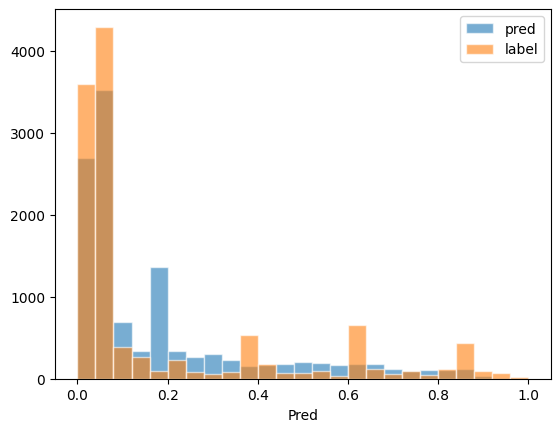

In [40]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [41]:
#pred_df = test.copy()
pred_lgbm = np.mean(preds_lgbm, axis=1)
pred_cat = np.mean(preds_cat, axis=1)

pred = (pred_lgbm + pred_cat) / 2

pred_df["pred_lgbm"] = pred_lgbm
pred_df["pred_cat"] = pred_cat
pred_df["pred"] = pred

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_lastyear_feature56,knn_lastyear_feature108,knn_lastyear_feature74,main_pred,sea_pred,landsat_pred,last_year_landsat_pred,pred_lgbm,pred_cat,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.0,0.0,0.0,0.030816,-0.010784,0.188975,0.278140,0.105388,0.079942,0.092665
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.099350,0.047481,0.055999,0.088488,0.081975,0.066146,0.074060
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.0,0.0,0.0,0.455490,0.075310,0.124247,0.031221,0.054687,0.067749,0.061218
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.039567,0.059341,0.051703,0.045531,0.059379,0.058592,0.058985
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.0,0.0,0.0,0.232364,0.326314,0.481086,0.285849,0.361539,0.365227,0.363383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.0,0.0,0.0,0.255388,-0.022587,0.249109,0.245054,0.172376,0.100498,0.136437
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.139790,0.033583,0.052470,0.119710,0.057925,0.069628,0.063777
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.0,0.0,0.0,0.432453,0.041005,0.165249,0.295922,0.035847,0.092173,0.064010
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.0,0.0,0.0,0.189546,0.263860,0.161360,0.050390,0.118602,0.149491,0.134047


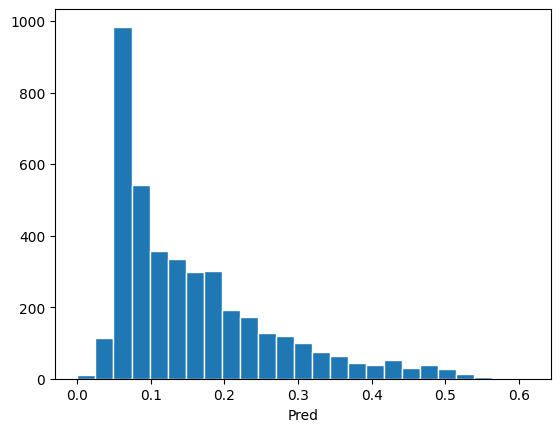

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_lastyear_feature56,knn_lastyear_feature108,knn_lastyear_feature74,main_pred,sea_pred,landsat_pred,last_year_landsat_pred,pred_lgbm,pred_cat,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.0,0.0,0.0,0.030816,-0.010784,0.188975,0.278140,0.105388,0.079942,0.092665
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.099350,0.047481,0.055999,0.088488,0.081975,0.066146,0.074060
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.0,0.0,0.0,0.455490,0.075310,0.124247,0.031221,0.054687,0.067749,0.061218
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.039567,0.059341,0.051703,0.045531,0.059379,0.058592,0.058985
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.0,0.0,0.0,0.232364,0.326314,0.481086,0.285849,0.361539,0.365227,0.363383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.0,0.0,0.0,0.255388,-0.022587,0.249109,0.245054,0.172376,0.100498,0.136437
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.139790,0.033583,0.052470,0.119710,0.057925,0.069628,0.063777
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.0,0.0,0.0,0.432453,0.041005,0.165249,0.295922,0.035847,0.092173,0.064010
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.0,0.0,0.0,0.189546,0.263860,0.161360,0.050390,0.118602,0.149491,0.134047


In [42]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_LGBM&CTB_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [43]:
pred_df.to_csv(os.path.join(OUTPUT_DIR, f'test_pred_LGBM&CTB_seed{CFG.seed}_ver{CFG.ver}.csv'))
_oof.to_csv(os.path.join(OUTPUT_DIR, f'OOF_LGBM&CTB_seed{CFG.seed}_ver{CFG.ver}.csv'))

In [44]:
pred_df[["pred_cat"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_CTB_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

In [45]:
pred_df[["sea_pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_ligntgbm_sea_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

In [46]:
pred_df[["pred_lgbm"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_ligntgbm_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)